## Imports and download

In [146]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    ! pip install datasets transformers
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")


Running as a Colab notebook


In [147]:
# from huggingface_hub import notebook_login

# notebook_login()

In [148]:
import transformers

print(transformers.__version__)

4.30.2


In [149]:
import torch
from torch.optim import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check if CUDA is available and choose device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [151]:
model_checkpoint = "distilgpt2"
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)
from transformers import AutoModelForCausalLM

In [152]:
# model = AutoModelForCausalLM.from_pretrained(model_checkpoint).to(device)
# model

## Hook into model and optimize sentence

In [153]:
def enembed(embeds_input):
  """
  Given an embedding vector, decode each token by using the transpose of the embedding matrix
  and grabbing the vocab token with the highest probability on each token.

  Also do this with the unembedding matrix as well.
  """
  with torch.no_grad():
      # Get the pre-trained embeddings
      pretrained_embeddings = model.transformer.wte.weight

      # Calculate dot product between input embeddings and pre-trained embeddings
      dot_product = torch.matmul(embeds_input, pretrained_embeddings.t())

      # Get the index of the highest value along dimension 2 (tokens)
      _, tokens = torch.max(dot_product, dim=2)

  # Decode tokens into text using the tokenizer
  text = tokenizer.batch_decode(tokens.tolist(), skip_special_tokens=True)

  return text

In [154]:
def optimize_for_neuron(starting_sentence, layer_num=1, neuron_index=0, mlp_or_attention="mlp"):
  """
  Args:
    neuron_indices: List of indices.
    mlp_or_attention (str): 'mlp' or 'attention'
  """
  model = AutoModelForCausalLM.from_pretrained(model_checkpoint).to(device)
  inputs = tokenizer(starting_sentence, return_tensors="pt").to(device)

  # Get embeddings
  with torch.no_grad():
      embeddings = model.transformer.wte(inputs["input_ids"])

  # Make embeddings require gradient
  embeddings.requires_grad_(True)

  # Create an optimizer for the embeddings
  optimizer = AdamW([embeddings], lr=0.1)  # You may need to adjust the learning rate
  pre_embeddings = embeddings.detach().clone()
  print(embeddings)
  print(enembed(pre_embeddings))
  len_example = embeddings.shape[1] - 1

  if 'mlp' in mlp_or_attention:
    layer = model.transformer.h[layer_num].mlp
  else:
    raise NotImplementedError("Haven't implemented attention block yet")
  activation_saved = [0.0]
  def hook(model, input, output):
    # The output is a tensor. You can index it to get the activation of a specific neuron.
    # Here we're getting the activation of the 0th neuron.
    activation = output[0, len_example, neuron_index]
    activation_saved[0] = activation
  handle = layer.register_forward_hook(hook)

  losses = []
  dist = 0.0
  for i in tqdm(range(100)):
    outputs = model(inputs_embeds=embeddings, attention_mask=inputs.attention_mask)
    loss = -torch.sigmoid(activation_saved[0])
    loss.backward()
    optimizer.step()
    dist = torch.sum(embeddings - pre_embeddings).item()
    losses.append(loss)
    if i % 25 == 0:
      tqdm.write(f"\n{dist} and then {loss}\n")
      tqdm.write(enembed(embeddings)[0])
    optimizer.zero_grad()

  return losses



tensor([[[-0.0139, -0.1037,  0.1125,  ...,  0.2844, -0.1100, -0.0665],
         [-0.0732,  0.0183,  0.0231,  ..., -0.0664,  0.0704, -0.0653],
         [ 0.0277, -0.1060, -0.0304,  ..., -0.1270, -0.1730,  0.2329],
         ...,
         [-0.0909,  0.0374,  0.0177,  ..., -0.0995, -0.1028, -0.0781],
         [ 0.1139,  0.2699, -0.0141,  ..., -0.1196, -0.1867,  0.0398],
         [ 0.0400, -0.0202,  0.0025,  ..., -0.0923,  0.0308,  0.1553]]],
       device='cuda:0', requires_grad=True)
["In the midst of a vibrant summer morning, with the sun casting its golden rays upon the lush green meadows and the fragrant wildflowers swaying gently in the warm breeze, a multitude of birds chirped melodiously while gracefully soaring across the clear blue sky, their wings glimmering like tiny diamonds as they embraced the boundless freedom of the open air, and nearby, a majestic oak tree stood tall and proud, its branches extending outward in a magnificent display of nature's artistry, providing shade an

  0%|          | 0/100 [00:00<?, ?it/s]


4.193210601806641 and then -0.3522891104221344

In the midst of a vibrant summer morning, with the sun casting its golden rays upon the lush green meadows and the fragrant wildflowers swaying gently in the warm breeze, a multitude of birds chirped melodiously while gracefully soaring across the clear blue sky, their wings glimmering like tiny diamonds as they embraced the boundless freedom of the open air, and nearby, a majestic oak tree stood tall and proud, its branches extending outward in a magnificent display of nature's artistry, providing shade and shelter for a variety of creatures that sought solace beneath its protective canopy, including a family of squirrels playfully darting between the branches, their bushy tails serving as vibrant accents against the backdrop of verdant leaves, and as the day progressed, the distant rumble of thunder gradually grew louder, heralding the imminent arrival of a summer storm, as dark clouds gathered overhead, casting an ephemeral gloom over

 29%|██▉       | 29/100 [00:01<00:02, 23.92it/s]


-99.6822738647461 and then -0.9999935626983643

 Ruralagadvertisingofhop Flavoringutterstockterdayayarchagethelessitudesembercients rays uponagicultureeteenth exampleadows and the fragrantblersflowersoiseingflatac thethodox breeze. aELF of nestingiariesirpedurnalodiouslyions gracefully peacows the fundament
 sky. their fundamentglimmering like fundamentschild. theycients the mathematlessfreedom of theensibletheless. and locality. acientscientscyclopediasonian mathemat and eminent. its branches Parables�� in acientstheless ofcyclopediaist Parablesistry.gerycients andteenth for acyclopedia ofcyclopedia thatxualeteenthacerootschannelAvailabilitymbergcients.quickShipAvailable atheless ofcientss playfullytleing between the branches, their bushyteenththelessongcientstones against thetones of��dantcients, androp thetheless progressed, the distantaceaeble ofcientstymologycientsocene,cientsing theciationcients of atymologycients,ac sunsetcientscientsthood,cientsathtymologyhemeralcientsetonast 

 56%|█████▌    | 56/100 [00:02<00:01, 26.45it/s]


-104.24163055419922 and then -0.9999939203262329

 Ruralagadvertisingofhop Flavoringutterstockterdayayarchagethelessitudesembercients rays uponagicultureeteenth exampleadows and the fragrantblersflowersoiseingflatac thethodox breeze. aELF of nestingiariesirpedurnalodiouslyions gracefully peacows the fundament
 sky. their fundamentglimmering like fundamentschild. theycients the mathematlessfreedom of theensibletheless. & locality. whichcientscientscyclopediasonian mathemat and eminent.earth branches Parables��ine acientstheless ofcyclopediaist Parablesistry.gerycients andteenth for acyclopedia ofcyclopedia.xualeteenthacerootschannelAvailabilitymbergcients.quickShipAvailable atheless ofcientsspolefullytleing between theteenth, their buscientsteenthcientsongcientstones against thetones of��dantcients, androp thetheless progressed, the distantaceaeteenth ofcientstymologycientsocene,cientsing theciationcients of atymologycientsileac sunsetcientscientsthood,cientsathtymologyhemeralcientseto

 78%|███████▊  | 78/100 [00:03<00:00, 27.23it/s]


-101.14918518066406 and then -0.9999943971633911

 Ruralagadvertisingofhop Flavoringutterstockterdayayarchagethelessitudesembercients rays uponagicultureeteenth exampleadows and the fragrantblersflowersoiseingflatac thethodox breeze. aELF of nestingiariesirpedurnalodiouslyions gracefully peacows the fundament
 sky. their fundamentgeistimmering like fundamentschild. theycients the mathematlessfreedom of theensibletheless. & locality. whichcientscientscyclopediasonian mathemat and eminent.earth branches Parables��ine acientstheless ofcyclopediaist Parablesistry.gerycients andteenth for acyclopedia ofcyclopedia.xualeteenthacerootschannelAvailabilitymbergcients.quickShipAvailable atheless ofcientsspolefullytleing between theteenth, their buscientsteenthcientsongcientstones against thetones of��dantcients, androp thetheless progressed, the distantaceaeteenth ofcientstymologycientsocene,cientsing theciationcients of atymologycientsileac sunsetcientscientsthood,cientsathtymologyhemeralcients

100%|██████████| 100/100 [00:03<00:00, 26.52it/s]


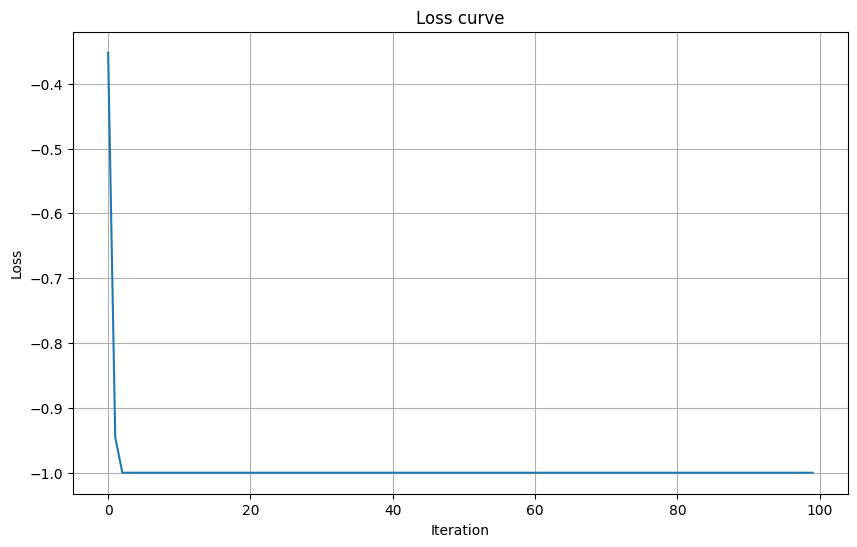

In [155]:
input_sentence = "In the midst of a vibrant summer morning, with the sun casting its golden rays upon the lush green meadows and the fragrant wildflowers swaying gently in the warm breeze, a multitude of birds chirped melodiously while gracefully soaring across the clear blue sky, their wings glimmering like tiny diamonds as they embraced the boundless freedom of the open air, and nearby, a majestic oak tree stood tall and proud, its branches extending outward in a magnificent display of nature's artistry, providing shade and shelter for a variety of creatures that sought solace beneath its protective canopy, including a family of squirrels playfully darting between the branches, their bushy tails serving as vibrant accents against the backdrop of verdant leaves, and as the day progressed, the distant rumble of thunder gradually grew louder, heralding the imminent arrival of a summer storm, as dark clouds gathered overhead, casting an ephemeral gloom over the once vibrant landscape, yet even in the face of this impending tempest, there was an undeniable beauty in the contrast between the electric flashes of lightning that briefly illuminated the sky and the cascading raindrops that danced upon the earth, breathing life into the thirsty soil and rejuvenating the flora and fauna, and as the storm subsided, a mesmerizing rainbow emerged, arching gracefully across the horizon, its vibrant hues painting a breathtaking scene that filled hearts with awe and wonder, reminding us of the ever-present magic and resilience of nature, and in that fleeting moment, as the world basked in the afterglow of the storm, a profound sense of gratitude and harmony washed over everything, reminding us of our intricate connection to the vast tapestry of existence."
losses = optimize_for_neuron(input_sentence, neuron_index=0)
# Plot losses
plt.figure(figsize=(10,6))
plt.plot([loss.cpu().detach() for loss in losses])
plt.title('Loss curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()